In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

# Part 2 

# Feature selection with OLS

In [2]:
#loading dataset
wine=pd.read_csv('winequality-red.csv')

<IPython.core.display.Javascript object>


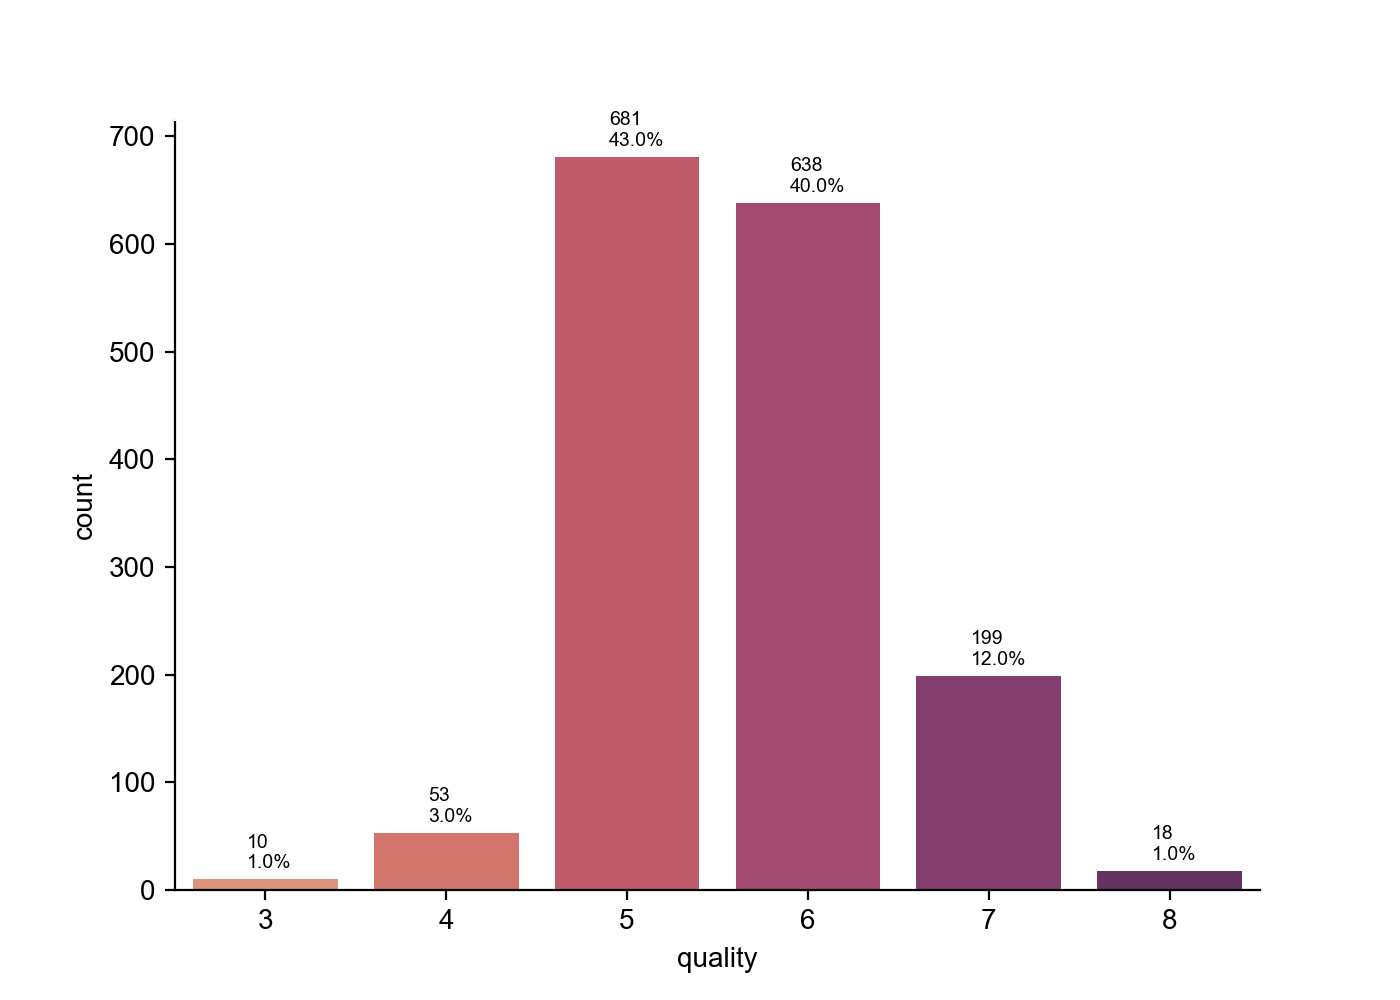

In [3]:
plt.figure(figsize=(7,5))
ax=sns.countplot(data=wine,x='quality',palette='flare')
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}\n{(p.get_height()/len(wine)*100).round(0)}%', (p.get_x()+0.3, p.get_height()+10), color='black', size=7)

    
ax.spines['top'].set_color('white') #setting right and top edge to invisible
ax.spines['right'].set_color('white')


plt.show()

In [4]:
#dropping duplicates and outliers

print(f'Number of data before removing duplicates is {wine.shape[0]}')

wine.drop_duplicates(inplace=True)
print(f'Number of data after removing duplicates is {wine.shape[0]}')

#cleaning outliers
X = wine.iloc[:, 0:11].values
y = wine.iloc[:, -1].values
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor()
yhat = lof.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1
X,y = X[mask, :], y[mask]
# summarize the shape of the updated dataset
print(f'Number of data after removing outliers is {X.shape[0]}');

Number of data before removing duplicates is 1599
Number of data after removing duplicates is 1359
Number of data after removing outliers is 1335


In [5]:
#splitting inot train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [6]:
#scaling the data before feature selection
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

import statsmodels.api as sm
#adding array of ones for OLS
x0=np.ones(1001).astype(int)
X_opt =np.insert(X_train, 0, x0, axis=1)

In [7]:
X_opt=X_opt[:,[0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary();

In [8]:
#removing x8
X_opt=X_opt[:, [0,1,2,3,4,5,6,7,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train, exog =X_opt).fit()
regressor_OLS.summary();

In [9]:
#removing x4
X_opt=X_opt[:, [0,1,2,3,5,6,7,8,9,10]]
regressor_OLS = sm.OLS(endog = y_train, exog =X_opt).fit()
regressor_OLS.summary();

In [10]:
#removing x5
X_opt=X_opt[:, [0,1,2,3,4,6,7,8,9]]
regressor_OLS = sm.OLS(endog = y_train, exog =X_opt).fit()
regressor_OLS.summary();

In [11]:
#removing x1
X_opt=X_opt[:, [0,2,3,4,5,6,7,8]]
regressor_OLS = sm.OLS(endog = y_train, exog =X_opt).fit()
regressor_OLS.summary();

In [12]:
#removing x2
X_opt=X_opt[:, [0,1,3,4,5,6,7]]
regressor_OLS = sm.OLS(endog = y_train, exog =X_opt).fit()
regressor_OLS.summary();

We eliminated 5 variables : fixed acidity, citric acid, residual sugar, free sulphor and pH. All these were values that had highest correlation with other features. 

# Building classification models and tuning hyperparameters

In [13]:
#defining new train set
X_train_2=X_train[:,[1,4,6,8,9,10]]
X_test_2=X_test[:,[1,4,6,8,9,10]]

I will first try Naive Bayes

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, balanced_accuracy_score
nb_class=GaussianNB()
nb_class.fit(X_train_2,y_train)

y_pred=nb_class.predict(X_test_2)

print(f'\nAccuracy score is {accuracy_score(y_test,y_pred)} and balanced accuracy score is \
{balanced_accuracy_score(y_test,y_pred)}\n')

from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=[3,4,5,6,7,8], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_nb=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 3','class 4','class 5','class 6','class 7','class 8']])

results_nb


Accuracy score is 0.562874251497006 and balanced accuracy score is 0.3673457618770119



,class 3,class 4,class 5,class 6,class 7,class 8
Precision,0.0,0.0,0.69,0.51,0.57,0.5
Recall,0.0,0.0,0.56,0.63,0.51,0.5
f score,0.0,0.0,0.62,0.57,0.54,0.5
Support,2.0,9.0,154.00,128.00,39.00,2.0


Naive Bayes picked some of the class 7 and 8 but the percentage for classes with the majority data are around 60%

In [15]:
w={3:0.1,4:0.4,5:4.2,6:3.9,7:1.2,8:0.1}

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,GridSearchCV
import warnings
warnings.filterwarnings('ignore')
log_class = LogisticRegression(class_weight=w ,multi_class='multinomial',random_state = 0,max_iter=500)
log_class.fit(X_train_2, y_train)

cross_val_score(log_class,X_train_2,y_train,cv=5,scoring='accuracy',n_jobs=-1);

In [17]:
#cross validation score is telling me that there could be some imporvement so I will proceed with the grid search. 


log_class = LogisticRegression(multi_class='multinomial',random_state = 0,max_iter=500)

lr_grid=GridSearchCV(estimator=log_class,
                      param_grid={'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20),
                                  'solver' : ['newton-cg','lbfgs'],'class_weight':[w]},
                     cv=5,verbose=0, n_jobs=-1)
lr_grid.fit(X_train_2,y_train)

lr_grid.best_params_

{'C': 0.08858667904100823,
 'class_weight': {3: 0.1, 4: 0.4, 5: 4.2, 6: 3.9, 7: 1.2, 8: 0.1},
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [18]:
log_class = LogisticRegression(class_weight=w,C=0.08,penalty='l2',solver='newton-cg',multi_class='multinomial',random_state = 0)
log_class.fit(X_train_2, y_train)

y_pred=log_class.predict(X_test_2)

#presenting results in dataframe
print(f'\nAccuracy score is {accuracy_score(y_test,y_pred)} and balanced accuracy score is {balanced_accuracy_score(y_test,y_pred)}\n')
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=[3,4,5,6,7,8], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_lr=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                        index=[['Precision','Recall','f score','Support']],
                        columns=[['class 3','class 4','class 5','class 6','class 7','class 8']])

results_lr


Accuracy score is 0.5778443113772455 and balanced accuracy score is 0.22965229215229213



,class 3,class 4,class 5,class 6,class 7,class 8
Precision,0.0,0.0,0.65,0.50,1.00,0.0
Recall,0.0,0.0,0.73,0.62,0.03,0.0
f score,0.0,0.0,0.69,0.55,0.05,0.0
Support,2.0,9.0,154.00,128.00,39.00,2.0


<IPython.core.display.Javascript object>


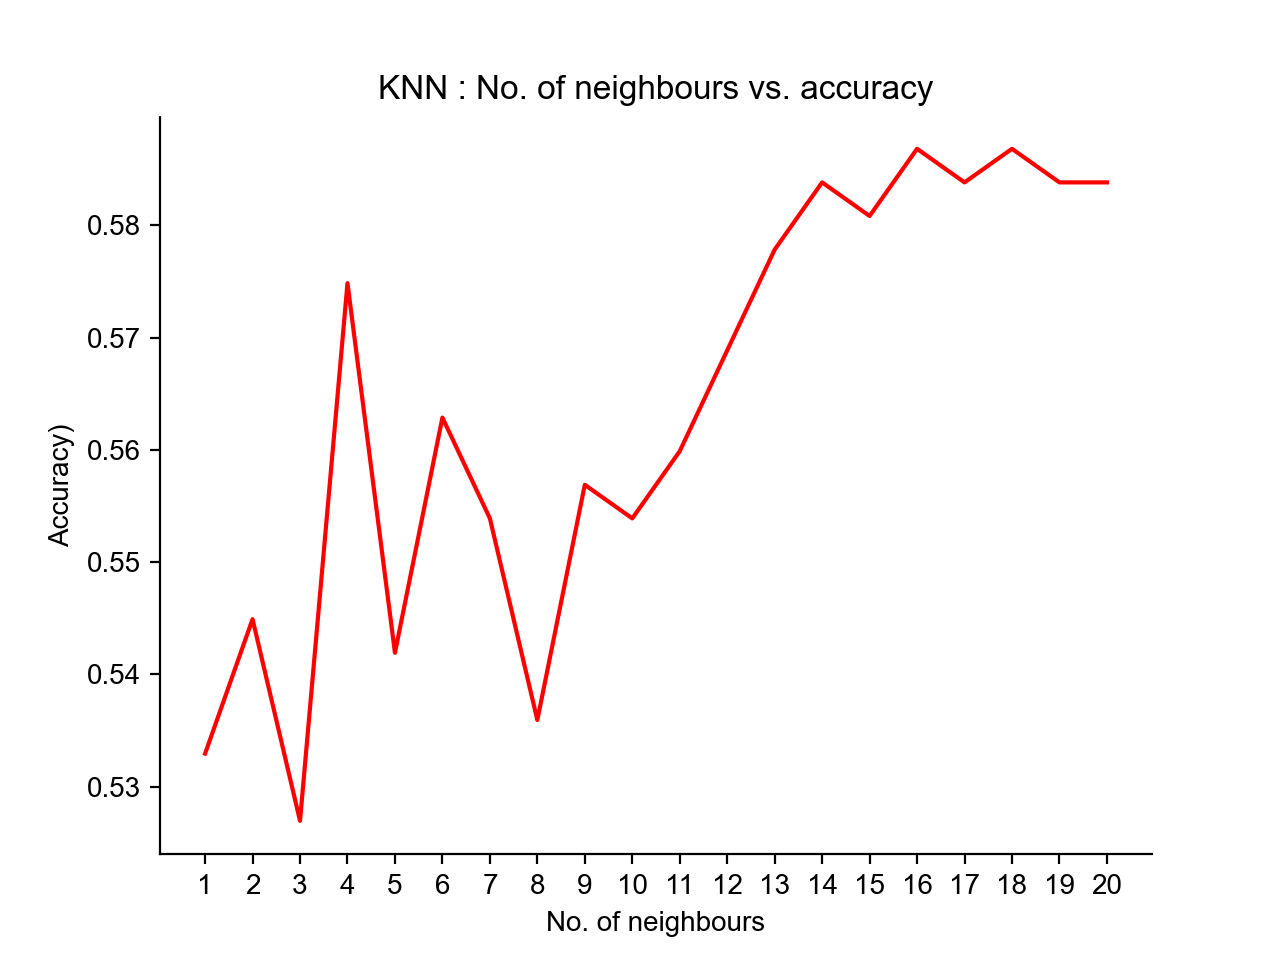

In [19]:
#for KNN I will plot results and choose the optimum number of neighbours
from sklearn.neighbors import KNeighborsClassifier
acc=[1]*20
for n in range (1,21):
    knn_class = KNeighborsClassifier(n_neighbors = n, metric = 'minkowski', p = 2)
    knn_class.fit(X_train_2, y_train)
    y_pred = knn_class.predict(X_test_2)
    acc[n-1]=accuracy_score(y_test,y_pred)

n=list(np.linspace(1,20,20)) 
plt.figure()
plt.plot(n,acc,color='red')

plt.xticks(ticks=list(np.linspace(1,20,20)))
plt.title(f'KNN : No. of neighbours vs. accuracy')
plt.xlabel('No. of neighbours')
plt.ylabel('Accuracy)')

ax=plt.gca() #setting right and top edge as invisible
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

plt.show()

We can see from above theat the highest accuracy is for n=18 or n=19. Since it is very small difference I will chose 18 as it is less computationally expensive.

In [20]:
knn_class = KNeighborsClassifier(n_neighbors = 18, metric = 'minkowski', p = 2)
knn_class.fit(X_train_2, y_train)
y_pred = knn_class.predict(X_test_2)

print(f'\nAccuracy score is {accuracy_score(y_test,y_pred)} and balanced accuracy score is {balanced_accuracy_score(y_test,y_pred)}\n')


#presenting results in dataframe
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=[3,4,5,6,7,8], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_knn=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 3','class 4','class 5','class 6','class 7','class 8']])

results_knn


Accuracy score is 0.5868263473053892 and balanced accuracy score is 0.27416550463425465



,class 3,class 4,class 5,class 6,class 7,class 8
Precision,0.0,0.0,0.64,0.52,0.70,0.0
Recall,0.0,0.0,0.67,0.62,0.36,0.0
f score,0.0,0.0,0.65,0.56,0.47,0.0
Support,2.0,9.0,154.00,128.00,39.00,2.0


For rest of the classifiers I will reppeat the same procedure:
-run cross validation to check on "possible" accuracy
-run GridSearch and cross validation in order to tune hyperparameters.

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

sv_class = SVC(class_weight=w,kernel = 'rbf',C=2, random_state = 0,probability=True)
sv_class.fit(X_train_2, y_train)

cross_val_score(sv_class,X_train_2,y_train,cv=5,scoring='accuracy',n_jobs=-1);

In [22]:
from sklearn.model_selection import GridSearchCV, cross_val_score

sv_class=SVC()

sv_grid=GridSearchCV(estimator=sv_class,
                      param_grid={'C': [1,10,100],'gamma': [0.0001, 0.001,0.01,1],
                                 'kernel':['linear','rbf'],'class_weight':[w]},
                     cv=5,verbose=0, n_jobs=-1)
sv_grid.fit(X_train_2,y_train)

sv_grid.best_params_;

In [23]:
sv_class = SVC(class_weight=w,kernel = 'rbf',C=100, gamma=0.001, random_state = 0)
sv_class.fit(X_train_2, y_train)

y_pred=sv_class.predict(X_test_2)

print(f'\nAccuracy score is {accuracy_score(y_test,y_pred)} and balanced accuracy score is {balanced_accuracy_score(y_test,y_pred)}\n')

#presenting results in dataframe
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=[3,4,5,6,7,8], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)
results_svc=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 3','class 4','class 5','class 6','class 7','class 8']])

results_svc


Accuracy score is 0.5718562874251497 and balanced accuracy score is 0.22407670454545456



,class 3,class 4,class 5,class 6,class 7,class 8
Precision,0.0,0.0,0.65,0.49,0.0,0.0
Recall,0.0,0.0,0.73,0.62,0.0,0.0
f score,0.0,0.0,0.69,0.54,0.0,0.0
Support,2.0,9.0,154.00,128.00,39.0,2.0


In [24]:
from sklearn.tree import DecisionTreeClassifier
tree_class = DecisionTreeClassifier(class_weight=w,random_state = 0)
tree_class.fit(X_train_2, y_train)

cross_val_score(sv_class,X_train_2,y_train,cv=5,scoring='accuracy',n_jobs=-1);

In [25]:
tree_class=DecisionTreeClassifier()

parameters = {"criterion":['gini','entropy'],
              "max_depth" : [None,1,2,3,4,5,6],"max_features":[None,"log2","sqrt"],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
              'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
              'class_weight':[w]
             }

tree_grid=GridSearchCV(estimator=tree_class,
                      param_grid=parameters,cv=5,verbose=0, n_jobs=-1)

tree_grid.fit(X_train_2,y_train)

tree_grid.best_params_;

In [26]:
tree_class = DecisionTreeClassifier(class_weight=w,criterion='entropy',max_depth=5,max_features='sqrt', 
                                    min_samples_leaf=8, min_samples_split=4,random_state=0)
tree_class.fit(X_train_2, y_train)

y_pred=tree_class.predict(X_test_2)

print(f'\nAccuracy score is {accuracy_score(y_test,y_pred)} and balanced accuracy score is {balanced_accuracy_score(y_test,y_pred)}\n')

#presenting results in dataframe
p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=[3,4,5,6,7,8], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)

results_tree=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 3','class 4','class 5','class 6','class 7','class 8']])

results_tree


Accuracy score is 0.5508982035928144 and balanced accuracy score is 0.21342329545454544



,class 3,class 4,class 5,class 6,class 7,class 8
Precision,0.0,0.0,0.61,0.47,0.0,0.0
Recall,0.0,0.0,0.77,0.51,0.0,0.0
f score,0.0,0.0,0.68,0.49,0.0,0.0
Support,2.0,9.0,154.00,128.00,39.0,2.0


In [27]:
from sklearn.ensemble import RandomForestClassifier
forest_class = RandomForestClassifier(class_weight=w,n_estimators = 10, random_state = 0)
forest_class.fit(X_train_2, y_train)

cross_val_score(sv_class,X_train_2,y_train,cv=5,scoring='accuracy',n_jobs=-1);

In [28]:
forest_class = RandomForestClassifier()
parameters = { 'bootstrap': [True,False], 'max_depth': [5, 10, 20,None],
              'max_features': [None,'auto', 'sqrt'],
              'n_estimators': [5, 6, 7, 8, 9, 10,20,40],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
              'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
             'class_weight':[w]}

forest_grid=GridSearchCV(forest_class,param_grid=parameters,scoring='accuracy', cv=5, verbose=0,n_jobs=-1)

forest_grid.fit(X_train_2,y_train)

forest_grid.best_params_;

In [29]:
forest_class = RandomForestClassifier(class_weight=w,bootstrap=True, max_depth=10, max_features='sqrt', min_samples_leaf=10,
                                      min_samples_split=4 ,n_estimators = 8, random_state = 0)
forest_class.fit(X_train_2, y_train)

y_pred=forest_class.predict(X_test_2)

print(f'Accuracy score is {accuracy_score(y_test,y_pred)} and balanced accuracy score is {balanced_accuracy_score(y_test,y_pred)}')

p, r, f, s = precision_recall_fscore_support(
    y_test,
    y_pred,
    labels=[3,4,5,6,7,8], # the labels for which we want the metrics determined
    average=None, # when None, returns a metric per label
)

results_forest=pd.DataFrame(data=[p.round(2),r.round(2),f.round(2),s],
                         index=[['Precision','Recall','f score','Support']],
                         columns=[['class 3','class 4','class 5','class 6','class 7','class 8']])

results_forest

Accuracy score is 0.5688622754491018 and balanced accuracy score is 0.22662537115662115


,class 3,class 4,class 5,class 6,class 7,class 8
Precision,0.0,0.0,0.65,0.49,1.00,0.0
Recall,0.0,0.0,0.70,0.63,0.03,0.0
f score,0.0,0.0,0.68,0.55,0.05,0.0
Support,2.0,9.0,154.00,128.00,39.00,2.0


# Part 3
# PRC or ROC-AUC?

In [30]:
print('Naive Bayes\n',results_nb,'\nLogistic classification\n',results_lr,'\nKNN\n',results_knn,'\nRandom Forest\n',results_forest)

Naive Bayes
           class 3 class 4 class 5 class 6 class 7 class 8
Precision     0.0     0.0    0.69    0.51    0.57     0.5
Recall        0.0     0.0    0.56    0.63    0.51     0.5
f score       0.0     0.0    0.62    0.57    0.54     0.5
Support       2.0     9.0  154.00  128.00   39.00     2.0 
Logistic classification
           class 3 class 4 class 5 class 6 class 7 class 8
Precision     0.0     0.0    0.65    0.50    1.00     0.0
Recall        0.0     0.0    0.73    0.62    0.03     0.0
f score       0.0     0.0    0.69    0.55    0.05     0.0
Support       2.0     9.0  154.00  128.00   39.00     2.0 
KNN
           class 3 class 4 class 5 class 6 class 7 class 8
Precision     0.0     0.0    0.64    0.52    0.70     0.0
Recall        0.0     0.0    0.67    0.62    0.36     0.0
f score       0.0     0.0    0.65    0.56    0.47     0.0
Support       2.0     9.0  154.00  128.00   39.00     2.0 
Random Forest
           class 3 class 4 class 5 class 6 class 7 class 8
Precision  

Those models predicted the 3 majority classess with avearge precision-recall scores, but the lower classes predictions were not good. The lower calsses account for only 6% of data. Wines are rerely graded that low so in oiur case we are not interested very much oin precision/recall of minority class. 

In that case the micro-precision/recall is the appropriate measure. 

<IPython.core.display.Javascript object>


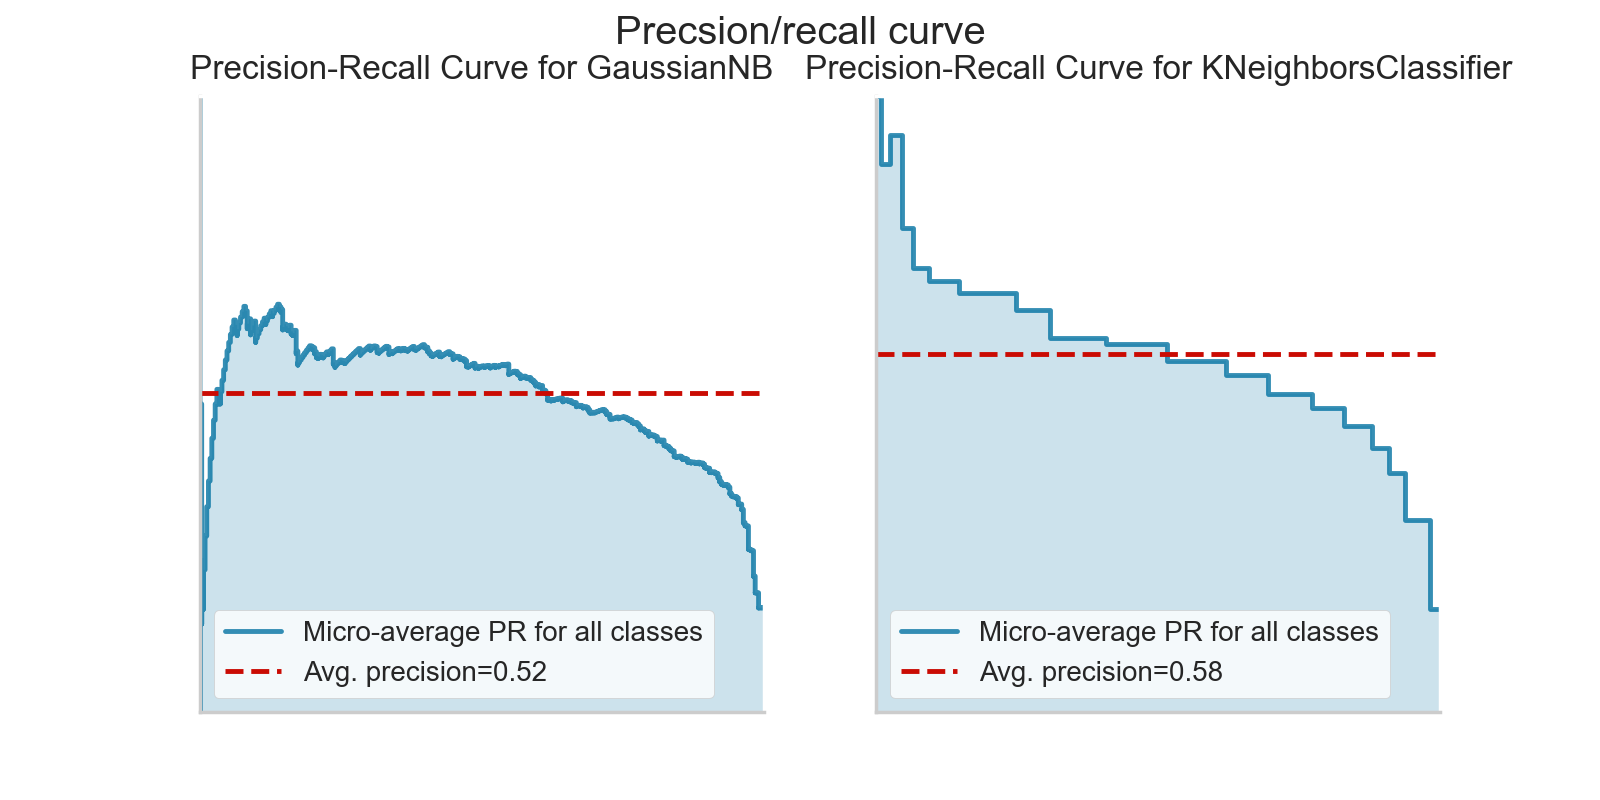

In [33]:
from yellowbrick.classifier import PrecisionRecallCurve 

fig,((ax1,ax2))=plt.subplots(1,2,sharex=True, sharey=True, figsize=(8,4))
plt.suptitle('Precsion/recall curve\n\n')

axs=[ax1,ax2]
classes=wine['quality'].sort_values().unique()

models=[nb_class,knn_class]

for n, classifier in enumerate(models):
    
    visualizer = PrecisionRecallCurve(classifier,classes=classes,ax=axs[n])
    visualizer.fit(X_train_2, y_train) # Fit the training data to the visualizer
    visualizer.score(X_test_2, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and show the figure
    plt.show()
    
for n in range(0,2):
    axs[n].spines['top'].set_color('white')
    axs[n].spines['right'].set_color('white')
    axs[n].xaxis.set_visible(False)
    axs[n].yaxis.set_visible(False)

In [34]:
models=[log_class,forest_class]

for classifier in models:
    p, r, f, s = precision_recall_fscore_support(y_test,classifier.predict(X_test_2),
                                             labels=[3,4,5,6,7,8],average='micro')
    
    print(f'Average micro precision for {classifier}\nfor all classes is {p.round(2)}\n')


Average micro precision for LogisticRegression(C=0.08,
                   class_weight={3: 0.1, 4: 0.4, 5: 4.2, 6: 3.9, 7: 1.2,
                                 8: 0.1},
                   multi_class='multinomial', random_state=0,
                   solver='newton-cg')
for all classes is 0.58

Average micro precision for RandomForestClassifier(class_weight={3: 0.1, 4: 0.4, 5: 4.2, 6: 3.9, 7: 1.2,
                                     8: 0.1},
                       max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=4, n_estimators=8, random_state=0)
for all classes is 0.57



Based on precision results KNN and Logistic Regression are performing the best. HOwever our score is still affected by our imbalanced data. 

One way to ov3rcome this would be to redefine wine quality and make two classes : "average": for wines with quality <6 and "good": for wines with quality bigger than 5. 

# Why ROC-AUC score is not a good indicator of model performance for imbalanced data ?

The next visualization will help us see how the roc-auc score can be misleading for imbalanced data

<IPython.core.display.Javascript object>


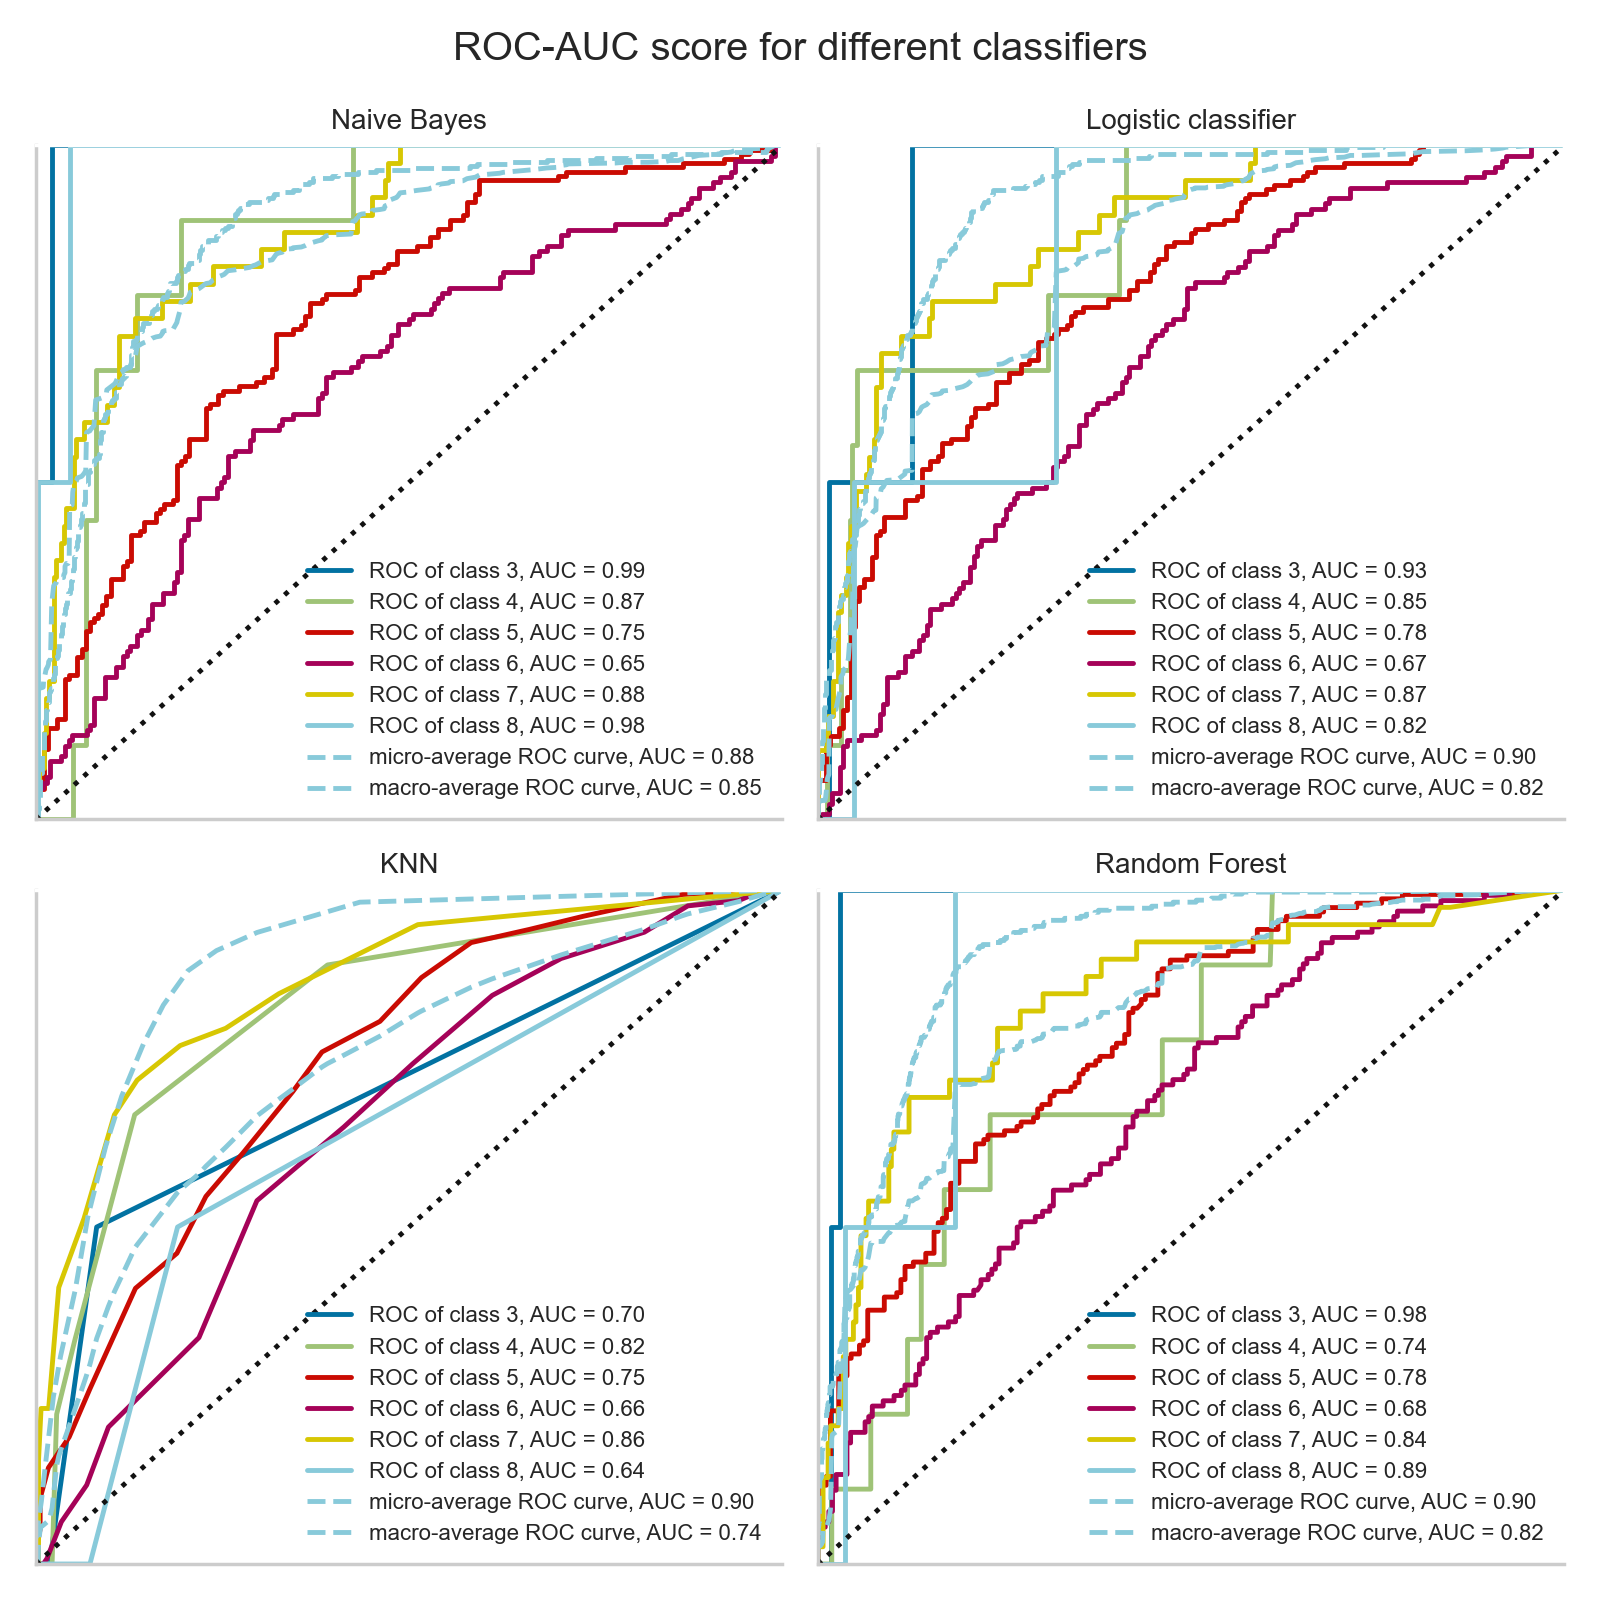

In [35]:
from yellowbrick.classifier import ROCAUC
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,sharex=True, sharey=True, figsize=(8,8))
plt.suptitle('ROC-AUC score for different classifiers')

axs=[ax1,ax2,ax3,ax4]
classes=wine['quality'].sort_values().unique()

models=[nb_class,log_class,knn_class, forest_class]
for n, classifier in enumerate(models):
    
    visualizer = ROCAUC(classifier, classes=classes,encoder={3:3,4:4,5:5,6:6,7:7,8:8},ax=axs[n])
    visualizer.fit(X_train_2, y_train)
    visualizer.score(X_test_2, y_test)
    visualizer.show()
    axs[n].legend(fontsize=8)
    plt.show()
    
ax1.set_title('Naive Bayes',size=10)
ax2.set_title('Logistic classifier',size=10)
ax3.set_title('KNN',size=10)
ax4.set_title("Random Forest",size=10)



for n in range(0,4):
    axs[n].spines['top'].set_color('white')
    axs[n].spines['right'].set_color('white')
    axs[n].xaxis.set_visible(False)
    axs[n].yaxis.set_visible(False)


plt.tight_layout()